In [173]:
import numpy as np
import scipy
import bitarray
import skimage
import cv2
import skimage.io as io
from matplotlib import pyplot as plt
import sys

# JPEG Compression 

Lucas Leandro Ribeiro 2018046815 <br> Wesley XXXX XXXX

In [288]:
stepsX = 0 # numero de blocos8 horizontal
stepsY = 0 # numero de blocos8 vertical


# FAZ O PADDING SE A IMAGEM NAO FOR MULTIPLO DE 8
def multiple_of_8_padding(image):
    h,w = image.shape[:2]
    if (h % 8 != 0) or (w % 8 != 0):
        h_pad = h + (8 - h % 8)
        w_pad = w + (8 - w % 8)
        pad_image = np.zeros((h_pad, w_pad), dtype=np.float32)
        pad_image[:h, :w] = image
        print("Padding: ", image.shape, " >> ", pad_image.shape)
        return pad_image
    else:
        return image
    

# DIVIDE EM BLOCOS
def divideBlocks(img):
    
    matrixes = [] # armazenar os blocos

    for i in range(stepsY):
        for j in range(stepsX):
            matrixes.append((img[ i * 8 : (i + 1) * 8, j * 8 : (j + 1) * 8 ]))
            
    return matrixes


# MONTA DE VOLTA A IMAGEM
def joinBlocks(matrixes):

    imgRec = [] # imagem de retorno
    col = 0 # controla num de blocos8 na horizontal
    line = [] # monta linha para concatenar na imagem

    for i in range(len(matrixes)):
        
            if (len(line) > 0):
                line = np.concatenate((line, np.array(matrixes[i])), axis=1) # join blocos na horizontal
            else:
                line = np.array(matrixes[i])
                
            col += 1 # anda 1 bloco8 pra direita
            
            if(col == stepsX): # chegou no ultimo bloco8 da linha

                if (len(imgRec) > 0):
                    imgRec = np.concatenate((imgRec, line), axis=0) # join linha de blocos na vertical
                else:
                    imgRec = line

                line = []
                col = 0 # volta pra x = 0

                continue
                
    return imgRec        

# ZIG ZAG JPEG PARA AGRUPAR COEFICIENTES 
def zig_zag_scan(matrix):
    rows = matrix.shape[0]
    cols = matrix.shape[1]
    num_diag = rows + cols - 1

    out = [[] for i in range(num_diag)]

    for i in range(rows):
        for j in range(cols):
            sum=i+j

            if(sum%2 ==0):
                out[sum].insert(0,matrix[i][j]) # adiciona no inicio da diagonal
            else:
                out[sum].append(matrix[i][j]) # adiciona no final da diagonal


    return [item for sublist in out for item in sublist]


def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)


def showImg(img):
    plt.imshow(img, cmap='gray')
    plt.show()

### Quantization Matrix 

In [304]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# quantization matrix
QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

In [305]:
img = cv2.imread('image.jpeg',cv2.IMREAD_GRAYSCALE)
stepsX = int(img.shape[1]/8) # numero de blocos8 horizontal
stepsY = int(img.shape[0]/8) # numero de blocos8 vertical


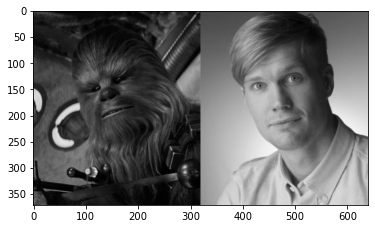

In [306]:
showImg(img)

Padding:  (371, 640)  >>  (376, 648)


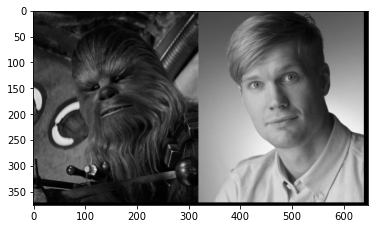

In [307]:
img = multiple_of_8_padding(img)
showImg(img)

### DCT

In [308]:
matrixes = divideBlocks(img)

bloco = matrixes[0]
bloco = bloco - 128

# dct calcula a similaridade do bloco com cada um dos padrões de frequencia
# vai dar valores mais altos pro padrao relacionado, ex: borda horiz, borda vert, freq alta, freq baix..
dct = cv2.dct(np.float32(bloco))

# bloco quantizado
qDct = np.divide(dct, QM)

print(qDct)

[[-33.5    -0.586  -0.029  -0.997   0.49    0.502   0.512   0.501]
 [  3.467  -0.998  -1.017   2.115   0.502   0.006  -0.5     0.006]
 [  0.007   0.543   0.016  -0.      0.006   0.005   0.      0.006]
 [  0.487   0.541  -0.505   0.022   0.001  -0.002  -0.005   0.001]
 [ -0.486   0.017  -0.01    0.004   0.007  -0.003   0.004  -0.004]
 [ -0.011  -0.015  -0.003  -0.008   0.003   0.002   0.001  -0.   ]
 [  0.005  -0.002   0.     -0.001  -0.001  -0.003   0.002   0.003]
 [ -0.002  -0.     -0.007   0.003   0.006   0.001  -0.001   0.001]]


In [309]:
# compression rate
newSize = sys.getsizeof(qDct) * 8
oriSize = sys.getsizeof(matrixes[0]) * 8
print(newSize, "b --> ", oriSize, "b") # bytes
print("compression rate dct: ", oriSize/newSize)

1216 b -->  1024 b
compression rate dct:  0.8421052631578947


### Zig-Zag 

In [310]:
coef = zig_zag_scan(np.array(qDct))
print(coef)


[-33.5, -0.585723486813632, 3.4673245747884116, 0.006833632609673909, -0.9975021680196127, -0.028536295890808104, -0.9968339800834656, -1.0170307840619768, 0.5430775422316331, 0.48747406687055317, -0.4861111111111111, 0.5409446043126723, 0.01562498975545168, 2.1146175986842106, 0.4895833333333333, 0.5016897678375244, 0.501738218160776, -0.00033717222201327485, -0.5047160928899591, 0.01677893508564342, -0.010629492501417795, 0.004713670939815288, -0.01533993993486677, -0.009899160346469364, 0.021962788598290806, 0.005774247273802757, 0.006198092781264207, 0.5116786956787109, 0.5005435005563205, -0.4998218536376953, 0.005369818524310463, 0.0006795794356103037, 0.004489092422383172, -0.0029052764177322386, -0.001946986885741353, -0.0018270274417267905, -0.000450832931243855, 2.161376809722125e-09, -0.007865898311138153, 0.007352941176470588, -0.0017225673829001941, 7.1008279835792646e-09, 0.005674139477989891, 0.006004032811948231, -0.005226616933941841, -0.002596653382712548, 0.003042589

In [311]:
# caminho inverso

# bloco dequantizado
dqDct = np.multiply(qDct, QM)

# dct inversa
iDct = cv2.idct(dqDct)

bloco = iDct + 128


print(bloco - matrixes[0])

print ("RMSE: %5.3f" % rmse(matrixes[0], bloco))
print ("PSNR: %5.3f" % psnr(matrixes[0], bloco))

[[ 0.  0.  0.  0. -0. -0.  0. -0.]
 [-0.  0. -0. -0.  0. -0. -0. -0.]
 [-0.  0.  0.  0.  0. -0. -0.  0.]
 [-0. -0. -0. -0.  0. -0.  0. -0.]
 [ 0.  0.  0.  0.  0. -0. -0.  0.]
 [ 0.  0. -0. -0. -0.  0. -0. -0.]
 [ 0.  0.  0.  0.  0. -0. -0.  0.]
 [-0.  0. -0.  0. -0.  0. -0.  0.]]
RMSE: 0.000
PSNR: 168.162
